## Training, Evaluating, and Conforming a Model for Deployment
In this notebook, we demonstrate the process of

1. simple cleaning, feature engineering, and feature selection of a dataset,
2. training a model,
3. evaluating model performance,
4. saving (pickling) the model (and other assets) for later use,
5. and conforming the code for deployment

More specifically, we will train a linear regression predictor on the Ames Housing Data dataset.

Let's load in the necessary libraries. We will be using `sklearn` to train the model.

In [314]:
import pickle
import pandas
import numpy
import matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

pandas.options.mode.chained_assignment = None

**I - Data Cleaning, Feature Engineering, and Feature Selection**

The **Ames Housing Data** dataset can be found [at this link](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). Download the train dataset (we will be using it exclusively as it has SalePrice, the ground truth feature to use with for monitoring) and load it into a Pandas DataFrame.

In [315]:
df = pandas.read_csv('./data/house_price_data.csv')

Let's look at a sample of the data:

In [316]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Before proceeding, let's split the original dataset into two sets: a **baseline** set which will be used as a reference set, and a **sample** set which will mimic input data to the model once the model is in use.

In [317]:
df_baseline, df_sample = train_test_split(df, train_size=0.8, random_state=42)

df_baseline_scored = df_baseline.copy(deep=True) # Will hold model output
df_sample_scored = df_sample.copy(deep=True)

df_baseline.to_json('./data/df_baseline.json', orient='records', lines=True)
df_sample.to_json('./data/df_sample.json', orient='records', lines=True)

Let's **clean up** the data. There are quite a few null values in the dataset and we'll fill them in with appropriate values. Note that these steps will also be necessary once we conform the model for deployment.

In [318]:
print('Numerical features that contain 1 or more missing values:')
for col, dtype in df.dtypes.items():
    num_missigns = df[col].isna().sum()
    if dtype not in ['object', 'category'] and num_missigns > 0:
        print('- ', col, ': \t', num_missigns)

Numerical features that contain 1 or more missing values:
-  LotFrontage : 	 259
-  MasVnrArea : 	 8
-  GarageYrBlt : 	 81


In [319]:
print('Categorical features that contain 1 or more missing values:')
for col, dtype in df.dtypes.items():
    num_missigns = df[col].isna().sum()
    if dtype in ['object', 'category'] and num_missigns > 0:
        print('- ', col, ': \t\t', num_missigns)

Categorical features that contain 1 or more missing values:
-  Alley : 		 1369
-  MasVnrType : 		 8
-  BsmtQual : 		 37
-  BsmtCond : 		 37
-  BsmtExposure : 		 38
-  BsmtFinType1 : 		 37
-  BsmtFinType2 : 		 38
-  Electrical : 		 1
-  FireplaceQu : 		 690
-  GarageType : 		 81
-  GarageFinish : 		 81
-  GarageQual : 		 81
-  GarageCond : 		 81
-  PoolQC : 		 1453
-  Fence : 		 1179
-  MiscFeature : 		 1406


In [320]:
# Imputing missing GarageYrBlt values with corresponding YearBuilt values
df_baseline['GarageYrBlt'] = df_baseline['GarageYrBlt'].fillna(df_baseline['YearBuilt'])
df_sample['GarageYrBlt'] = df_sample['GarageYrBlt'].fillna(df_sample['YearBuilt'])

In [321]:
# Imputing MasVnrArea missing values with 0 
df_baseline['MasVnrArea'] = df_baseline['MasVnrArea'].fillna(0)
df_sample['MasVnrArea'] = df_sample['MasVnrArea'].fillna(0)

In [322]:
# Imputing LotFrontage missing values with the median value of the neighborhood
df_baseline['LotFrontage'] = df_baseline.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df_baseline['LotFrontage'] = df_baseline['LotFrontage'].fillna(0)
df_sample['LotFrontage'] = df_sample.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df_sample['LotFrontage'] = df_sample['LotFrontage'].fillna(0)

/home/semerhi/.pyenv/versions/3.8.3/envs/house_price_383_env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [323]:
# Imputing the rest of the missing values in categorical features with 'None'
for col in list(df.select_dtypes(include=['object', 'category'])):
    df_baseline[col] = df_baseline[col].fillna('None')
    df_sample[col] = df_sample[col].fillna('None')

In [324]:
assert df_baseline.isna().sum().sum()==0
assert df_sample.isna().sum().sum()==0

Next, let's write up some functions that will convert some categorical features into numerical features, then apply those functions to our data.

In [325]:
# Many columns use this generic scale
generic = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0}
garage_finish = {"Fin": 3, "RFn": 2, "Unf": 1, "None": 0}
fin_type = {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "None": 0}
functional = {
    "Typ": 7,
    "Min1": 6,
    "Min2": 5,
    "Mod": 4,
    "Maj1": 3,
    "Maj2": 2,
    "Sev": 1,
    "None": 0,
}


In [326]:
# Generic conversions
generic_columns = [
    "ExterQual",
    "BsmtQual",
    "ExterCond",
    "BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "GarageQual",
    "GarageCond",
    "PoolQC",
    "FireplaceQu"
]
for col in generic_columns:
    df_baseline[col] = df_baseline[col].map(generic)
    df_sample[col] = df_sample[col].map(generic)


In [327]:
# FinType conversionss
fintype_columns = ['BsmtFinType1', 'BsmtFinType2']
for col in fintype_columns:
    df_baseline[col] = df_baseline[col].map(fin_type)
    df_sample[col] = df_sample[col].map(fin_type)

In [328]:
# Functional conversions
df_baseline['Functional'] = df_baseline['Functional'].map(functional)
df_sample['Functional'] = df_sample['Functional'].map(functional)

In [329]:
# GarageFinish conversions
df_baseline['GarageFinish'] = df_baseline['GarageFinish'].map(garage_finish)
df_sample['GarageFinish'] = df_sample['GarageFinish'].map(garage_finish)

We also have the `MSSubClass` numerical column which should be treated as a categorical column. We will convert this into an object column to later be one-hot-encoded.

In [330]:
df_baseline['MSSubClass'] = df_baseline['MSSubClass'].astype(str)
df_sample['MSSubClass'] = df_sample['MSSubClass'].astype(str)

In [331]:
assert df_baseline.isna().sum().sum()==0
assert df_sample.isna().sum().sum()==0

Our data still contains non-predictive features, such as `Id` and `SalePrice`. We will set these aside and remove them the final list of predictive features.

In [332]:
df_baseline_ids = df_baseline['Id']
df_sample_ids = df_sample['Id']

predictive_features = sorted(
    list(set(df_baseline.columns) - set(["Id", "SalePrice"]))
)

We'll proceed with model training. We need to specify **predictive** and **response** variables for each of the training and test sets.

In [333]:
X_train = df_baseline[predictive_features]
X_test = df_sample[predictive_features]

y_train = df_baseline['SalePrice']
y_test = df_sample['SalePrice']

Let's take a look at which columns contain muerical data and which contain categorical data. Some categorical features can easily be converted to numerical, as they might be ordinal. Other categorical features will have to be one-hot-encoded.

In [334]:
categorical_features = sorted(
    list(
        set(predictive_features).intersection(
            set(X_train.select_dtypes(include=["object", "category"]))
        )
    )
)
numerical_features = sorted(
    list(
        set(predictive_features).intersection(
            set(X_train.select_dtypes(include=["number"]))
        )
    )
)

**Categorical Features**

In [335]:
print(categorical_features)

['Alley', 'BldgType', 'BsmtExposure', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'Foundation', 'GarageType', 'Heating', 'HouseStyle', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']


**Numerical Features**

In [336]:
print(numerical_features)

['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'FireplaceQu', 'Fireplaces', 'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'HeatingQC', 'KitchenAbvGr', 'KitchenQual', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'PoolQC', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']


Next, we One-Hot-Encode categoricals.

In [337]:
X_train = pandas.get_dummies(X_train, columns=categorical_features)
X_test = pandas.get_dummies(X_test, columns=categorical_features)

Let's do some **feature engineering**. While this portion of a data science project can be lengthy, we'll be doing some basic feature engineering in this example. A few ones that might be helpful are boolean features like `HasGarage` or `HasBsmt` and additive features like `TotalSF` or `TotalBathrooms`. We'll be adding `e` as a prefix to these columns to show that they have been engineered.

In [338]:
for data in [X_train, X_test]:
    #  Computing total square footage as a new feature
    data["eTotalSF"] = data["TotalBsmtSF"] + data["1stFlrSF"] + data["2ndFlrSF"]

    #  Computing total 'porch' square-footage as a new feature
    data["eTotalPorchSF"] = (
        data["OpenPorchSF"]
        + data["3SsnPorch"]
        + data["EnclosedPorch"]
        + data["ScreenPorch"]
        + data["WoodDeckSF"]
    )

    #  Computing total bathrooms as a new feature
    data["eTotalBathrooms"] = (
        data["FullBath"]
        + (0.5 * data["HalfBath"])
        + data["BsmtFullBath"]
        + (0.5 * data["BsmtHalfBath"])
    )


In [339]:
# Engineering some features into Booleans
for data in [X_train, X_test]:
    data["eHasPool"] = data["PoolArea"] > 0
    data["eHasGarage"] = data["GarageArea"] > 0
    data["eHasBsmt"] = data["TotalBsmtSF"] > 0
    data["eHasFireplace"] = data["Fireplaces"] > 0
    # Feature to determine if a house had a remodeling
    data["eHasRemodeling"] = (data["YearRemodAdd"] - data["YearBuilt"]) > 0


Let's engineer one more feature, `OverallQual_TotalSF`. This feature will be the multiplication of the `OverallQual` and `TotalSF` features. This specific combination of features, in fact, has the highest correlation to `SalePrice`.

In [340]:
for data in [X_train, X_test]:
    data['eOverallQual_TotalSF'] = data['OverallQual'] * data['eTotalSF']

Let's move on to **feature selection**. We want our final model to only have a limited number of features, as too many features will cause the model to overfit, though too little will not allow our model to perform well. We'll take a look at the correlation of `SalePrice` to all other columns to determine which ones have the most predictive power, and choose 10 features to predict with.

In [341]:
X_train['SalePrice'] = y_train
high_corr_columns = [(col, round(corr, 2)) for col, corr in X_train.corr()['SalePrice'].items() if abs(corr) >= 0.4]
high_corr_columns.sort(key=lambda x:x[1], reverse=True)
high_corr_columns

[('SalePrice', 1.0),
 ('eOverallQual_TotalSF', 0.84),
 ('OverallQual', 0.79),
 ('eTotalSF', 0.77),
 ('GrLivArea', 0.7),
 ('ExterQual', 0.67),
 ('KitchenQual', 0.66),
 ('GarageCars', 0.64),
 ('GarageArea', 0.62),
 ('eTotalBathrooms', 0.62),
 ('TotalBsmtSF', 0.6),
 ('1stFlrSF', 0.59),
 ('BsmtQual', 0.59),
 ('FullBath', 0.55),
 ('GarageFinish', 0.55),
 ('FireplaceQu', 0.52),
 ('TotRmsAbvGrd', 0.52),
 ('YearBuilt', 0.52),
 ('GarageYrBlt', 0.51),
 ('YearRemodAdd', 0.51),
 ('Foundation_PConc', 0.49),
 ('eHasFireplace', 0.47),
 ('Fireplaces', 0.46),
 ('MasVnrArea', 0.46),
 ('HeatingQC', 0.44)]

In [342]:
# The final list of encoded columns - dropping SalePrice (target)
train_encoded_columns = list(list(zip(*high_corr_columns))[0][1:])

**II - Training the model**

Let's move on to training the model. Let's first restrict our feature space to only be that of the final list of columns. We'll be saving this list, as we'll need it when we deploy the model.

In [343]:
# restricting X_train and X_test columns to only be final list of columns
X_train = X_train[train_encoded_columns]
X_test = X_test[train_encoded_columns]

# Saving the final list of encoded columns
pickle.dump(train_encoded_columns, open('./binaries/train_encoded_columns.pickle', 'wb'))

Another thing we can do to make our model a bit more performant, as well as explainable, is to standardize the features. This will allow us to interpret the weights on each feature directly against each other.

In [344]:
X_test.dtypes

eOverallQual_TotalSF      int64
OverallQual               int64
eTotalSF                  int64
GrLivArea                 int64
ExterQual                 int64
KitchenQual               int64
GarageCars                int64
GarageArea                int64
eTotalBathrooms         float64
TotalBsmtSF               int64
1stFlrSF                  int64
BsmtQual                  int64
FullBath                  int64
GarageFinish              int64
FireplaceQu               int64
TotRmsAbvGrd              int64
YearBuilt                 int64
GarageYrBlt             float64
YearRemodAdd              int64
Foundation_PConc          uint8
eHasFireplace              bool
Fireplaces                int64
MasVnrArea              float64
HeatingQC                 int64
dtype: object

In [346]:
standard_scaler = StandardScaler()
X_train_ss = standard_scaler.fit_transform(X_train.values)
X_test_ss = standard_scaler.transform(X_test.values)
pickle.dump(standard_scaler, open('./binaries/standard_scaler.pickle', 'wb'))

One last thing we can do is to apply a logarithm to `SalePrice`. If we look at the distribution of values for `SalePrice`, we  notice that there is a right skew, with values at the top of the distribution quite distant from the average value of the distribution.

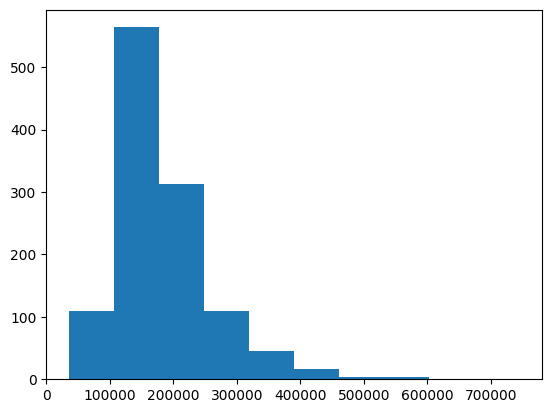

In [347]:
import matplotlib.pyplot as plt
plt.hist(y_train)
plt.show()

Applying a logarithm will allow the distribution to be centralized. We'll specifically use the `numpy.log1p()` function in case that there are values are 0. 

In [348]:
y_train_log = numpy.log1p(y_train)
y_test_log = numpy.log1p(y_test)

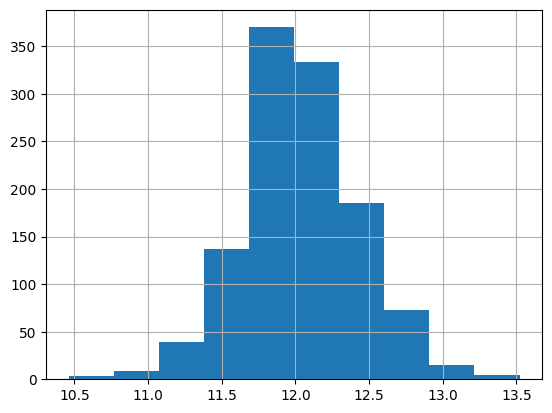

In [349]:
y_train_log.hist();

The distribution is now roughly normalized, and the model should be able to predict better. One thing we need to keep in mind, however, is that if we want predictions, we will have to inverse the logarithm on the outputs of the model.

We will train a **Lasso** linear regression model. Let's fit the model to the training data.

In [350]:
# Finding the cross-validation score with 5 (default) folds, 
# showing how the model should generally perform, irrespective to how the data was split
cross_val_score(LassoCV(max_iter=5000), X_train_ss, y_train_log).mean()

0.826654198290621

In [351]:
lasso = LassoCV(max_iter=5000)
lasso.fit(X_train_ss, y_train_log)

LassoCV(max_iter=5000)

In [352]:
lasso.score(X_train_ss, y_train_log)

0.8524822989875176

In [353]:
lasso.score(X_test_ss, y_test_log)

0.8574187125985915

**III - Model Evaluation**

Before saving our trained model for further use, let's take a look at some performance metrics. We will evaluate the model on both the training and test sets; we want to see a stable performance between the two.  

For repeatability, let's define a function which computes multiple metrics at once.

In [354]:
def compute_regression_metrics(y_true: pandas.Series, y_preds: pandas.Series) -> dict:
    """
    A function to evaluate a regression model.

    Args:
        y_true (pandas.Series): true (ground truth) values
        y_preds (pandas.Series): predicted values (as predicted by model)

    Returns:
        (dict): Multiple regression performance metrics: MAE, RMSE, r2_score
    """

    return {
        "Mean Absolute Error": numpy.round(mean_absolute_error(y_true, y_preds), 2),
        "Root Mean Squared Error": numpy.round(
            mean_squared_error(y_true, y_preds) ** 0.5, 2
        ),
        "R2 Score": numpy.round(r2_score(y_true, y_preds), 3),
    }


Let's compute predictions on both training and test sets. Remember, we need to apply an inverse log to convert the outputs into the same units as our inputs.

In [355]:
y_train_preds = numpy.round(numpy.expm1(lasso.predict(X_train_ss)), 2)
y_test_preds = numpy.round(numpy.expm1(lasso.predict(X_test_ss)), 2)

In [356]:
performance_df = pandas.DataFrame(
    data=[{}],
    columns=['Mean Absolute Error', 'Root Mean Squared Error', 'R2 Score'],
    index=['Training Set', 'Test Set']
)
performance_df.loc['Training Set', :] = compute_regression_metrics(y_train, y_train_preds)
performance_df.loc['Test Set', :] = compute_regression_metrics(y_test, y_test_preds)

Let's look at how our model performed:

In [357]:
performance_df

,Mean Absolute Error,Root Mean Squared Error,R2 Score
Training Set,19555.96,33471.99,0.812
Test Set,20984.15,34891.06,0.841


The performanc meterics are comparable between the two sets.

**IV - Saving and Loading the Trained Model**

Now that the model is **trained** and **evaluated**, we save it in a binary format. It will later be loaded and used to make new predictions.

In [358]:
pickle.dump(lasso, open('./binaries/lasso_regression.pickle', 'wb'))

The model is reloaded on-demands as follows:

In [359]:
lasso_loaded = pickle.load(open('./binaries/lasso_regression.pickle', 'rb'))

Predictions can be produced on-demand by calling the `predict()` function:

In [360]:
new_preds = lasso_loaded.predict(X_test)

/home/semerhi/.pyenv/versions/3.8.3/envs/house_price_383_env/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(


Before heading into the next section, let's append our predictions to our `_scored` DataFrames and save them. Once again, these data sets will be used mainly for monitoring purposes. Note that the features on these datasets will be the final list of features used that the model expects during prediction.

In [361]:
all_cols = train_encoded_columns.copy()

all_cols.append('SalePrice')

cols_reordered = ['Id', 'prediction', 'SalePrice']
cols_reordered.extend(train_encoded_columns)

X_train['SalePrice'] = y_train
X_test['SalePrice'] = y_test

df_baseline_scored = X_train[all_cols]
df_baseline_scored['prediction'] = y_train_preds
df_baseline_scored['Id'] = df_baseline_ids
df_baseline_scored = df_baseline_scored[cols_reordered]

df_sample_scored = X_test[all_cols]
df_sample_scored['prediction'] = y_test_preds
df_sample_scored['Id'] = df_sample_ids
df_sample_scored = df_sample_scored[cols_reordered]

df_baseline_scored.to_json('./data/df_baseline_scored.json', orient='records', lines=True)
df_sample_scored.to_json('./data/df_sample_scored.json', orient='records', lines=True)

**V - Preparing Model Code for Deployment**

Conformance is best demonstrated through example. Let's look at the code below:

In [362]:
train_encoded_columns

['eOverallQual_TotalSF',
 'OverallQual',
 'eTotalSF',
 'GrLivArea',
 'ExterQual',
 'KitchenQual',
 'GarageCars',
 'GarageArea',
 'eTotalBathrooms',
 'TotalBsmtSF',
 '1stFlrSF',
 'BsmtQual',
 'FullBath',
 'GarageFinish',
 'FireplaceQu',
 'TotRmsAbvGrd',
 'YearBuilt',
 'GarageYrBlt',
 'YearRemodAdd',
 'Foundation_PConc',
 'eHasFireplace',
 'Fireplaces',
 'MasVnrArea',
 'HeatingQC']

In [1]:
import logging
import pickle
from typing import List

import pandas
import numpy
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

logger = logging.getLogger(__name__)
logging.basicConfig(level="INFO")


def init() -> None:
    """
    A function to load the trained model artifacts (.pickle files) as a glocal variables.
    These will be used by other functions to produce predictions.
    """

    global lasso_model
    global standard_scaler
    global train_encoded_columns

    # Load pickled Lasso linear regression model
    lasso_model = pickle.load(open("./binaries/lasso_regression.pickle", "rb"))
    # Load pickled standard scaler
    standard_scaler = pickle.load(open("./binaries/standard_scaler.pickle", "rb"))
    # Load train_encoded_columns
    train_encoded_columns = pickle.load(
        open("./binaries/train_encoded_columns.pickle", "rb")
    )

    logger.info(
        "'lasso_regressin.pickle', 'standard_scaler.pickle', and 'train_encoded_columns.pickle' \
        files loaded to respective variables"
    )


def score(data: dict) -> dict:
    """
    A function to predict hopuse sale price, given information about the property.

    Args:
        data (dict): input dictionary to be scored, containing predictive features.

    Returns:
        (dict): Scored (predicted) input data.
    """

    # Turn input data into a 1-record DataFrame
    logger.info("Loading input record into a pandas.DataFrame")
    input_data = pandas.DataFrame([data])

    # Process input_data
    logger.info("Applying inmputations, feature eng, and scaling to input_data")
    input_data = process(
        input_data=input_data, 
        train_encoded_columns=train_encoded_columns,
        apply_scaler=True,
        standard_scaler=standard_scaler
    )

    # Generate predictions
    logger.info("Generating predictions with the model and appending onto DataFrame")
    input_data.loc[:, "prediction"] = numpy.round(
        numpy.expm1(lasso_model.predict(input_data.values)), 2
    )

    return input_data.to_dict(orient="records")


def metrics(metrics_data: pandas.DataFrame) -> dict:
    """
    A function to compute regression metrics on scored and labeled data.

    Args:
        data (pandas.DataFrame): Dataframe of houses, including ground truths, predictions.

    Returns:
        (dict): MAE, RMSE, r2_score.
    """

    logger.info("Grabbing relevant columns to calculate metrics")
    y = metrics_data["SalePrice"]
    y_preds = metrics_data["prediction"]

    logger.info("Computing MAE, RMSE, R2 scores")
    output_metrics = {
        "MAE": mean_absolute_error(y, y_preds),
        "RMSE": mean_squared_error(y, y_preds) ** 0.5,
        "R2": r2_score(y, y_preds),
    }

    logger.info("Metrics job complete!")

    return output_metrics


def train(training_data: pandas.DataFrame) -> None:
    """
    A function to retrain the Lasso model. The same encoded columns are
    usd from the initial training; howver, with new data, weights are likely
    to be different, and so is the standard scaler.

    The unction writes to ./retrained_binaries/ 2 pickle files, corresponding
    to the updated scaler and regression weights.

    Args:
        training_data (pandas.DataFrame): Data used to retrain the model. Must contain
            grount tuth ('SalePrice').
    """

    # Set aside ground truth to later re-append to dataframe
    y_train = training_data["SalePrice"]

    # process input data
    X_train = process(
        input_data=training_data, 
        train_encoded_columns=train_encoded_columns,
        apply_scaler=False
    )

    # Scale inputs
    standard_scaler = StandardScaler()
    standard_scaler.fit_transform(X_train.values)
    logger.info("Scaling data with standard scaler")
    X_train = pandas.DataFrame(
        standard_scaler.transform(X_train.values),
        index=X_train.index,
        columns=X_train.columns,
    )

    pickle.dump(
        standard_scaler, open("./retrained_binaries/standard_scaler.pickle", "wb")
    )

    # Apply log to distribution of y-values
    y_train_log = numpy.log1p(y_train)

    # Train and pickle model artifact
    logger.info("Fitting LASSO model")
    lasso = LassoCV(max_iter=1000)
    lasso.fit(X_train, y_train_log)
    logger.info("Pickling trained LASSO model")

    # Pickle file should be written to outputDir/
    with open("./retrained_binaries/lasso_regression.pickle", "wb") as lasso_file:
        pickle.dump(lasso, lasso_file)

    logger.info("Training job complete!")


def process(
    input_data: pandas.DataFrame,
    train_encoded_columns: List[str],
    apply_scaler: bool,
    standard_scaler: StandardScaler = None,
) -> pandas.DataFrame:
    """
    A function to apply imputations, feature engineering, scaling to input data.

    Args:
        input_data (pandas.DataFrame): Data to be processed.
        train_encoded_columns (List[str]): Columns produced and encoded by the training step.
        apply_scaler (bool): Flag to indicate whether to apply a pre-configured standard scaler.
        standard_scaler (sklearn.preprocessing._data.StandardScaler): Pre-trained standard scaler.
            Only used if apply_scaler=True.

    Returns:
        (pandas.DataFrame): Processed DataFrame.
    """

    # Dictionaries to convert values in certain columns
    generic = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0}
    garage_finish = {"Fin": 3, "RFn": 2, "Unf": 1, "None": 0}

    # Imputations
    logger.info("Imputing input dataset")
    input_data["GarageYrBlt"] = input_data["GarageYrBlt"].fillna(
        input_data["YearBuilt"]
    )
    for col in ["GarageFinish", "BsmtQual", "FireplaceQu"]:
        input_data[col] = input_data[col].fillna("None")
    # The rest of NaNs will be filled with 0s - end model only uses numerical features
    for col in input_data.columns:
        input_data[col] = input_data[col].fillna(0)

    generic_columns = [
        "ExterQual",
        "BsmtQual",
        "HeatingQC",
        "KitchenQual",
        "FireplaceQu",
    ]
    # Converting categorical values from certain features into numerical
    for col in generic_columns:
        input_data[col] = input_data[col].map(generic)

    input_data["GarageFinish"] = input_data["GarageFinish"].map(garage_finish)

    # Feature engineering
    input_data["eHasFireplace"] = input_data["Fireplaces"] > 0
    input_data["eTotalSF"] = (
        input_data["TotalBsmtSF"] + input_data["1stFlrSF"] + input_data["2ndFlrSF"]
    )
    input_data["eTotalBathrooms"] = (
        input_data["FullBath"]
        + (0.5 * input_data["HalfBath"])
        + input_data["BsmtFullBath"]
        + (0.5 * input_data["BsmtHalfBath"])
    )
    input_data["eOverallQual_TotalSF"] = (
        input_data["OverallQual"] * input_data["eTotalSF"]
    )

    input_data["Foundation_PConc"] = input_data["Foundation"] == "PConc"

    # Limiting features to just the ones the model needs
    logger.info("Selecting columns that model is expecting")
    input_data = input_data[train_encoded_columns]

    if apply_scaler:
        # Scale inputs
        logger.info("Scaling data with pickled standard scaler")
        input_data = pandas.DataFrame(
            standard_scaler.transform(input_data.values),
            index=input_data.index,
            columns=input_data.columns,
        )

    return input_data


There are five main sections to the code above:
1. Library imports
2. `init` function
3. `score` function
4. `metrics` function
5. `train` function

**Library** imports are always at the top. We don't need to include all libraries that we used for training and model evaluation. We just need the libraries for processing and scoring.

The **`init`** function runs once per deployment, and is used to load and persist into memory any variable that needs to be accessed at scoring time. For example, the init function is where we load the saved model binary, scalers, and any other dependencies. We make the variables global so they can be accessed from the scoring function. In our example, we also included the `train_encoded_columns` as this information will not change per prediction and only needs to be instantiated once.

The **`score`** function is the function that runs anytime we make a scoring (prediction) request. This is where we put our prediction code. We have to remember to include any steps that were not captured by the pipeline, such as feature engineering or re-encoding.

The **`metrics`** functions is where model evaluation is carried out. In our example, this is the place where we compute regression metrics.

The **`train`** function is where model (re)training is carried out.

Let us test our source code to see if we missed anything. We will load input data and scored input data to the scoring, metrics, and training functions:

In [2]:
# This is for the action function (scoring)
scoring_sample = pandas.read_json('./data/df_baseline.json', orient='records', lines=True)

# These are for the metrics function
metrics_baseline_input = pandas.read_json('./data/df_baseline_scored.json', orient='records', lines=True)
metrics_sample_input = pandas.read_json('./data/df_sample_scored.json', orient='records', lines=True)

Let's check that the **`init`** function can load the trained model binary:

In [3]:
init()

INFO:__main__:'lasso_regressin.pickle', 'standard_scaler.pickle', and 'train_encoded_columns.pickle'         files loaded to respective variables


No errors from the **`init`** function. Let's make a call to the **`score`** function on input data:

In [4]:
scores = pandas.DataFrame(
    score(scoring_sample.iloc[0]) # predicting on the first record
)

INFO:__main__:Loading input record into a pandas.DataFrame
INFO:__main__:Applying inmputations, feature eng, and scaling to input_data
INFO:__main__:Imputing input dataset
INFO:__main__:Selecting columns that model is expecting
INFO:__main__:Scaling data with pickled standard scaler
INFO:__main__:Generating predictions with the model and appending onto DataFrame


In [5]:
scores

,eOverallQual_TotalSF,OverallQual,eTotalSF,GrLivArea,ExterQual,KitchenQual,GarageCars,GarageArea,eTotalBathrooms,TotalBsmtSF,...,TotRmsAbvGrd,YearBuilt,GarageYrBlt,YearRemodAdd,Foundation_PConc,eHasFireplace,Fireplaces,MasVnrArea,HeatingQC,prediction
0,-0.394052,-0.820445,0.054233,-0.407093,-0.687421,-0.767076,-1.056544,-0.863837,-0.285144,0.572612,...,-0.964566,-0.455469,-0.737445,-1.346063,-0.895806,-1.065497,-0.958592,-0.597889,-1.168292,128695.92


We have scores! Next, et's call the **`metrics`** function on scored and labeled data:

In [6]:
metrics(metrics_baseline_input)

INFO:__main__:Grabbing relevant columns to calculate metrics
INFO:__main__:Computing MAE, RMSE, R2 scores
INFO:__main__:Metrics job complete!


{'MAE': 19555.955967465754,
 'RMSE': 33471.990156622014,
 'R2': 0.8121611766672495}

In [7]:
metrics(metrics_sample_input)

INFO:__main__:Grabbing relevant columns to calculate metrics
INFO:__main__:Computing MAE, RMSE, R2 scores
INFO:__main__:Metrics job complete!


{'MAE': 20984.14589041096,
 'RMSE': 34891.061953123615,
 'R2': 0.8412862541522661}

 Looks good! Finally, let's call he training function on labeled data:

In [8]:
train(scoring_sample)

INFO:__main__:Imputing input dataset
INFO:__main__:Selecting columns that model is expecting
INFO:__main__:Scaling data with standard scaler
INFO:__main__:Fitting LASSO model
INFO:__main__:Pickling trained LASSO model
INFO:__main__:Training job complete!


In [9]:
type(standard_scaler)

sklearn.preprocessing._data.StandardScaler

Perfect!